# 用于深度学习的 PyTorch构建Convolutional Neural Networks(CNN)卷积神经网络对Fashion-MNIST图像预测分类

## 数据集介绍 — Fashion Mnist
Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供，涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致，即60000/10000的训练测试数据划分和28x28的灰度图片。Fashion-Mnist数据集使大家可以不需要改动任何的代码，直接用它来测试机器学习和深度学习算法性能。

## 数据类别标注

| 标注编号 | 描述 | 
| --- | --- | 
| 0  | T-shirt/top（T恤）| 
| 1  | Trouser（裤子）|
| 2  | Pullover（套衫）|
| 3  | Dress（裙子）| 
| 4  | Coat（外套） |
| 5  | Sandal（凉鞋）| 
| 6  | Shirt（汗衫）|
| 7  | Sneaker（运动鞋）|
| 8  | Bag（包）|
| 9  | Ankle boot（踝靴）|


## 1. 导入需要的工具包

In [1]:
#导入需要的工具包
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import sys
import time
import numpy as np
import matplotlib.pyplot as plt

from IPython import display

print(torch.__version__)
print(torchvision.__version__)

1.11.0+cpu
0.12.0+cpu


## 2. 下载、导入数据集
#### Pytorch 的 torchvision 包含用于训练及测试的内置数据集，例如MNIST、FashionMnist等。作为预处理的一部分，需要对输入图像进行的转换列表可以使用 transforms.compose 来实现。下面，我们通过torchvision的torchvision.datasets包来下载这个数据集。第一次调用时会自动从网上获取数据。我们通过参数train来指定获取训练数据集或测试数据集。测试数据集也叫测试集（test_set），只用来评价模型的表现，并不用来训练模型。
#### 另外，我们还指定了参数transform=transform.ToTensor()使所有数据转换为Tensor，如果不进行转换则返回的是PIL图片。transform=transform.ToTensor()中transform.ToTensor()将尺寸为（H ∗ W ∗ C）且数据位于（0，255）的PIL图片或者数据类型为np.uint8的Numpy数组转换为尺寸为（C ∗ H ∗ W )且数据类型为torch.float32且位于（0.0，1.0）的Tensor。其中，C为通道个数（如果图像是灰色的，则C=1；如果图像是彩色的，则C=3）；H为图像高度；W为图像宽度。


In [2]:
# 训练集
train_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST',
                                              download = True,train = True,
                                              transform = transforms.Compose([transforms.ToTensor()]))
# 测试集
test_set = torchvision.datasets.FashionMNIST(root = './data/FashionMNIST',
                                             download=True,train=False,
                                             transform = transforms.Compose([transforms.ToTensor()]))

## 3. 数据加载
#### Pytorch 中的数据集类基本上涵盖了元组中的数据，使我们能够访问每个数据的索引。这是创建可用于洗牌、应用小批量梯度下降等所必需的数据加载器类。

In [3]:
#数据加载器
train_loader = torch.utils.data.DataLoader(train_set,batch_size=20)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=60000)
images, labels = next(iter(train_loader))

#### 训练数据集每个类别含有6000个样本，测试数据集每个类别含有1000个样本，一共有10个类别，故而训练数据集共60000个样本，测试数据集共10000个样本。

In [4]:
#数据集大小
print(type(train_set))
print(len(train_set), len(test_set))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


#### 变量feature对应高和宽均为28像素的图像。每个像素的数值为0到255之间8位无符号整数（uint8）。它使用三维的NDArray存储，其中的最后一维是通道数。因为数据集中图像为灰度图像，所以通道数为1。


In [5]:
#我们可以通过方括号[]来访问任意一个样本，下面获取第一个样本的图像和标签。
feature, label = train_set[0]
print(feature.shape, feature.dtype)  # Channel x Height X Width
print(label)

torch.Size([1, 28, 28]) torch.float32
9


#### 可视化显示

In [6]:
# 1）首先定义一个函数，根据数值标签获取字符串标签，将数值标签转成相应的文本标签
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [7]:
# 2）定义函数，一个可以在一行里画出多张图像和对应标签的函数
def show_fashion_mnist(images, labels):
    display.set_matplotlib_formats('svg') #用矢量图进行展示
    
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

C:\Users\user\AppData\Local\Temp/ipykernel_10048/2858995275.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg') #用矢量图进行展示


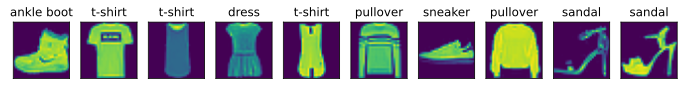

In [8]:
# 3）应用，看一下训练数据集中前10个样本的图像内容和文本标签
X, y = [], []
for i in range(10):
    X.append(train_set[i][0])
    y.append(train_set[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))


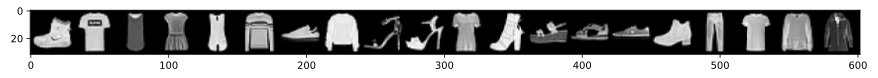

In [9]:
#用于创建图像网格（灰度图片，输出前20行）
grid = torchvision.utils.make_grid(images,nrow=20)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

#### 读取小批量数据
在深度学习模型中，优化参数时经常会用到小批量梯度下降（深度学习常称为随机梯度下降）算法，因此我们需每次读取小批量数据来进行每次迭代与更新。
PyTorch的DataLoader允许使用多进程来加速数据读取，通过参数num_workers来设置4个进程读取数据：
##### 这里我运行的时间是7.35秒

In [10]:
# 定义批次长度
batch_size = 256

if sys.platform.startswith('win'):
    # 0表示不使用额外的进程读取数据
    num_workers = 0
else:
    num_workers = 4
    
train_iter = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

#输出分批读取一遍训练数据需要的时间
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))

7.35 sec


## 4. 深度学习算法 — CNN 卷积神经网络

### CNN 最擅长的就是图片的处理。它受到人类视觉神经系统的启发。
### CNN 有2大特点（价值）：
##### 1）能够有效的将大数据量的图片降维成小数据量(并不影响结果)；
##### 2）能够有效的保留图片特征，类似人类的视觉原理，符合图片处理的原则。
### CNN 的基本原理：
##### 1）卷积层 – 主要作用是保留图片的特征
##### 2）池化层 – 主要作用是把数据降维，可以有效的避免过拟合
##### 3）全连接层 – 根据不同任务输出我们想要的结果

### 在 nn.conv2d 层的帮助下，可以在 pytorch 中实现卷积神经网络
nn.Conv2d 和 nn.Linear 是在 torch.nn 模块中定义的两个标准 PyTorch 层。二维卷积 nn.Conv2d 用于图像数据，对宽度和高度都进行卷积。PyTorch的nn.Linear（）是用于设置网络中的全连接层的。一旦定义了层，我们就可以使用层本身来计算每一层的前向结果，再加上激活函数（ReLu）和 Max Pooling 操作，我们可以很容易地编写我们网络的前向函数如上。在 fc1（完全连接层 1）上，我们使用了 PyTorch 的张量操作 x.reshape 来展平张量，以便之后可以将其传递给密集层。 此外，我们没有在输出层添加 softmax 激活函数，因为 PyTorch 的 CrossEntropy 函数会为我们处理这个问题。

#### 参数说明：
##### 1）in_channels：在文本应用中，即为词向量的维度
##### 2）out_channels：卷积产生的通道数，有多少个out_channels，就需要多少个一维卷积（也就是卷积核的数量）
##### 3）kernel_size：卷积核的尺寸；卷积核的第二个维度由in_channels决定，所以实际上卷积核的大小为kernel_size * in_channels
##### 4）padding：对输入的每一条边，补充0的层数

### 卷积层负责提取图像中的局部特征；池化层用来大幅降低参数量级(降维)；全连接层类似传统神经网络的部分，用来输出想要的结果。

In [11]:
class Network(nn.Module):
  def __init__(self):
    super(Network,self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
    self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
    self.fc2 = nn.Linear(in_features=120,out_features=60)
    self.fc3 = nn.Linear(in_features=60,out_features=40)
    self.out = nn.Linear(in_features=40,out_features=10)
  def forward(self,x):
    #输入层
    x = x
    #第一个隐藏层【输入x -> conv1 -> relu -> 2x2窗口的最大池化】
    x = self.conv1(x)
    x = F.relu(x)
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    #第二个隐藏层【输入x -> conv2 -> relu -> 2x2窗口的最大池化】
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x,kernel_size=2,stride=2)
    #第三个隐藏层【全连接层1】
    x = x.reshape(-1,12*4*4)
    x = self.fc1(x)
    x = F.relu(x)
    #第四个隐藏层【全连接层2】
    x = self.fc2(x)
    x = F.relu(x)
    #第五个隐藏层【全连接层3】
    x = self.fc3(x)
    x = F.relu(x)
    #输出层
    x = self.out(x)
    return x

#### 输出CNN模型的结构

In [12]:
# 定义模型
model = Network()

# 检查GPU是否可用
Dev = torch.device("cpu") 
if torch.cuda.is_available():
    Dev = torch.device("cuda")
model = model.to(Dev)

#打印模型
print(model)

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=10, bias=True)
)


## 5. 参数调整
#### 选择各种参数，例如 epoch 数、损失函数、学习率等

In [13]:
#定义参数，依次是：学习效率，优化器，损失函数，训练数据次数
learning_rate = 0.005
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()
epochs = 30

## 6. 训练
#### 为了最小化损失函数并提高准确性，从损失函数中找到的梯度将被用来改变权重的值，且这个过程会不断重复直至进程结束。

In [14]:
%%time
#训练循环
losses = []
for i in range(epochs):
  for j,(images,targets) in enumerate(train_loader):
    
    #做出预测
    y_pred = model(images)
  
    #计算损失
    loss = criterion(y_pred,targets.reshape(-1))
    #反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  if i>10:
    optimizer.lr = 0.0005
  print('Epoch:%d/%d'%(i+1,epochs),',',loss)
  losses.append(loss)

Epoch:1/30 , tensor(2.2979, grad_fn=<NllLossBackward0>)
Epoch:2/30 , tensor(1.9496, grad_fn=<NllLossBackward0>)
Epoch:3/30 , tensor(0.7173, grad_fn=<NllLossBackward0>)
Epoch:4/30 , tensor(0.5674, grad_fn=<NllLossBackward0>)
Epoch:5/30 , tensor(0.4945, grad_fn=<NllLossBackward0>)
Epoch:6/30 , tensor(0.4421, grad_fn=<NllLossBackward0>)
Epoch:7/30 , tensor(0.3932, grad_fn=<NllLossBackward0>)
Epoch:8/30 , tensor(0.3586, grad_fn=<NllLossBackward0>)
Epoch:9/30 , tensor(0.3337, grad_fn=<NllLossBackward0>)
Epoch:10/30 , tensor(0.3064, grad_fn=<NllLossBackward0>)
Epoch:11/30 , tensor(0.2911, grad_fn=<NllLossBackward0>)
Epoch:12/30 , tensor(0.2966, grad_fn=<NllLossBackward0>)
Epoch:13/30 , tensor(0.2880, grad_fn=<NllLossBackward0>)
Epoch:14/30 , tensor(0.2819, grad_fn=<NllLossBackward0>)
Epoch:15/30 , tensor(0.2781, grad_fn=<NllLossBackward0>)
Epoch:16/30 , tensor(0.2796, grad_fn=<NllLossBackward0>)
Epoch:17/30 , tensor(0.2705, grad_fn=<NllLossBackward0>)
Epoch:18/30 , tensor(0.2661, grad_fn=<Nl

## 7. 模型性能分析
#### 发现模型在测试集上的准确率为：88.26%

In [15]:
#模型的准确性
x_test,y_test = next(iter(test_loader))
y_pred = (model(x_test).argmax(dim=1))
print("Accuracy is : ",(y_pred.eq(y_test).sum()/10000.).item()*100,"%")

Accuracy is :  88.26000094413757 %


## 8. 绘图

Text(0, 0.5, 'loss')

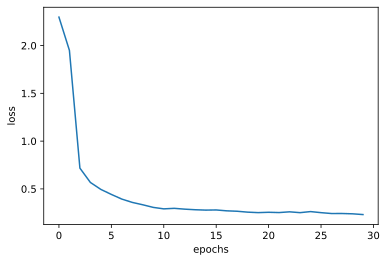

In [16]:
#绘图-损失值
losses1= [ loss.detach().numpy() for loss in losses]
plt.plot(losses1)
plt.xlabel('epochs')
plt.ylabel('loss')

## 9. 从测试集中进行随机预测
#### 得出的预测结果准确率也很高，从肉眼上看也是准确的。

This is a/an PullOver


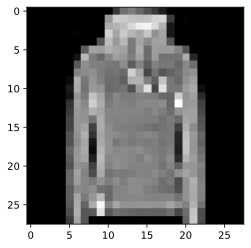

In [17]:
#随机预测
import random

rand_no = random.randint(0,10000)
order_list = "T-shirt/Top Trouser PullOver Dress Coat Sandal Shirt Sneaker Bag AnkleBoot".split()
plt.imshow(x_test[rand_no].reshape(28,28),cmap='gray')
pred = model(x_test[rand_no].reshape(-1,1,28,28)).argmax()
print("This is a/an {}".format(order_list[pred]))

## 10. 结论
#### 该模型在测试集上的准确率为 88.26%，由此知道卷积层的参数共享能力和边缘检测能力是很强的，同时也证明了卷积网络在预测图像方面的强大程度。

In [22]:
# 如果需要保存模型的参数，可以使用下列语句
torch.save(model.state_dict(), path)